## to do ...

### Arima/

### Is Data Stationary?

# Import Packages and Load Data

In [1]:
# colab only
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import warnings; 
warnings.simplefilter('ignore')

In [3]:
import pandas as pd
import seaborn as sns
import datetime as dt
import numpy as np

In [4]:
import plotly.express as px

In [5]:
from prophet import Prophet
from prophet.utilities import regressor_coefficients
from prophet.plot import plot_plotly, plot_components_plotly
from prophet.diagnostics import cross_validation
import plotly.graph_objects as go

from sklearn.metrics import r2_score 

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [6]:
# Right after importing seaborn (could also use 'whitegrid')
sns.set_theme(style='whitegrid', context='talk')
#surpress scientific notation
pd.options.display.float_format = '{:,.2f}'.format

# load data

In [7]:
df_full = pd.read_csv('data/data_full_clean.csv', index_col=0)
df_full.head()

Period                                          Commodity  \
0  2017-05-01  1605.30.10 - lobster, prepared or preserved, f...   
1  2017-05-01  1605.30.10 - lobster, prepared or preserved, f...   
2  2017-05-01   1605.30.90 - lobster, prepared or preserved, nes   
3  2017-05-01  1605.30.10 - lobster, prepared or preserved, f...   
4  2017-05-01   1605.30.90 - lobster, prepared or preserved, nes   

                    Province        Country          State  Quantity_kg  \
0  Newfoundland and Labrador  United States  Massachusetts        42059   
1              New Brunswick  United States  Massachusetts       370393   
2       Prince Edward Island  United States     California         1633   
3                     Quebec  United States     California         2347   
4       Prince Edward Island  United States  New Hampshire        15676   

   Value-adjusted  year               GDP-USD continent  
0    3,023,516.55  2017 19,477,336,549,000.00  Americas  
1   24,808,298.71  2017 19,477,336,549,000.00  Americas  
2       38,330.44  2017 19,477,336,549,000.00  Americas  
3      121,476.42  2017 19,477,336,549,000.00  Americas  
4      383,038.25  2017 19,477,336,549,000.00  Americas

In [8]:
# filter data only for USA countries
model_data = df_full[df_full['Country'].str.contains('United States')]
model_data

Period                                          Commodity  \
0      2017-05-01  1605.30.10 - lobster, prepared or preserved, f...   
1      2017-05-01  1605.30.10 - lobster, prepared or preserved, f...   
2      2017-05-01   1605.30.90 - lobster, prepared or preserved, nes   
3      2017-05-01  1605.30.10 - lobster, prepared or preserved, f...   
4      2017-05-01   1605.30.90 - lobster, prepared or preserved, nes   
...           ...                                                ...   
54047  1990-04-01  0306.22.10 - lobsters, (homarus spp), live (te...   
54048  1990-04-01  0306.12.90 - lobsters, (homarus spp), nes, fro...   
54049  1990-04-01  0306.22.90 - lobsters,(homarus spp), not froze...   
54050  1990-04-01  0306.12.90 - lobsters, (homarus spp), nes, fro...   
54051  1990-04-01  0306.22.10 - lobsters, (homarus spp), live (te...   

                        Province        Country          State  Quantity_kg  \
0      Newfoundland and Labrador  United States  Massachusetts        42059   
1                  New Brunswick  United States  Massachusetts       370393   
2           Prince Edward Island  United States     California         1633   
3                         Quebec  United States     California         2347   
4           Prince Edward Island  United States  New Hampshire        15676   
...                          ...            ...            ...          ...   
54047                Nova Scotia  United States          Maine       495399   
54048                Nova Scotia  United States  Massachusetts        22653   
54049              New Brunswick  United States  Massachusetts          998   
54050                     Quebec  United States  Massachusetts        92640   
54051                     Quebec  United States  Massachusetts         1361   

       Value-adjusted  year               GDP-USD continent  
0        3,023,516.55  2017 19,477,336,549,000.00  Americas  
1       24,808,298.71  2017 19,477,336,549,000.00  Americas  
2           38,330.44  2017 19,477,336,549,000.00  Americas  
3          121,476.42  2017 19,477,336,549,000.00  Americas  
4          383,038.25  2017 19,477,336,549,000.00  Americas  
...               ...   ...                   ...       ...  
54047    7,596,544.89  1990  5,963,144,000,000.00  Americas  
54048      967,469.26  1990  5,963,144,000,000.00  Americas  
54049        9,460.22  1990  5,963,144,000,000.00  Americas  
54050    1,441,995.60  1990  5,963,144,000,000.00  Americas  
54051       11,560.25  1990  5,963,144,000,000.00  Americas  

[26802 rows x 10 columns]

In [9]:
# filter for only relevant columns
model_data = model_data[['Period', 'Value-adjusted', 'GDP-USD']]
model_data

Period  Value-adjusted               GDP-USD
0      2017-05-01    3,023,516.55 19,477,336,549,000.00
1      2017-05-01   24,808,298.71 19,477,336,549,000.00
2      2017-05-01       38,330.44 19,477,336,549,000.00
3      2017-05-01      121,476.42 19,477,336,549,000.00
4      2017-05-01      383,038.25 19,477,336,549,000.00
...           ...             ...                   ...
54047  1990-04-01    7,596,544.89  5,963,144,000,000.00
54048  1990-04-01      967,469.26  5,963,144,000,000.00
54049  1990-04-01        9,460.22  5,963,144,000,000.00
54050  1990-04-01    1,441,995.60  5,963,144,000,000.00
54051  1990-04-01       11,560.25  5,963,144,000,000.00

[26802 rows x 3 columns]

In [10]:
model_data['Period'] = pd.to_datetime(model_data['Period'])

# Feature Engg / Preprocessing

<Axes: xlabel='Value-adjusted', ylabel='Count'>

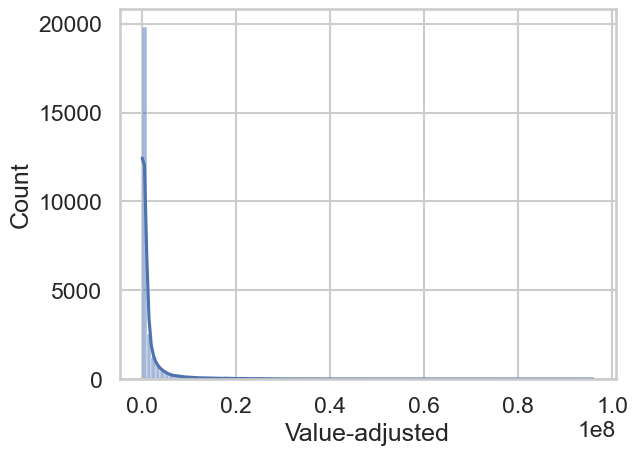

In [11]:
# value adjusted is highly skewed 
sns.histplot(model_data['Value-adjusted'], bins = 100, kde=True, log_scale=False)

<Axes: xlabel='Value-adjusted', ylabel='Count'>

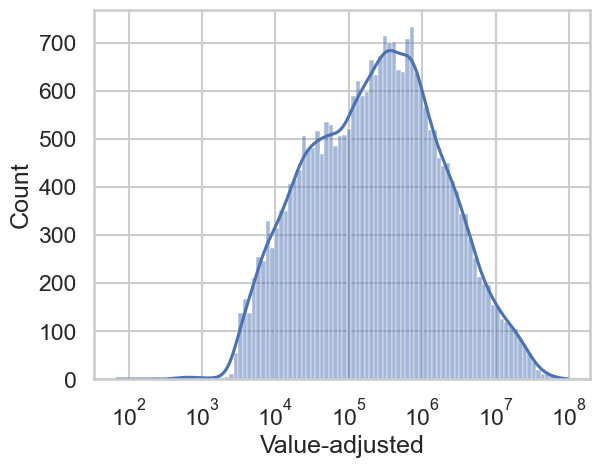

In [12]:
# when log scale applied, data becomes much more normally distributed
sns.histplot(model_data['Value-adjusted'], bins = 100, kde=True, log_scale=True)

# Facebook Prophet

In [13]:
def prophet_prep(df_name):
    df_name = df_name.rename(columns={ df_name.columns[0]: "ds" , df_name.columns[1]:'y'})
    df_name['ds'] = pd.to_datetime(df_name['ds'])
    return df_name

## Model 3: only for USA data

In [14]:
model_data = prophet_prep(model_data)

In [15]:
model_data

ds             y               GDP-USD
0     2017-05-01  3,023,516.55 19,477,336,549,000.00
1     2017-05-01 24,808,298.71 19,477,336,549,000.00
2     2017-05-01     38,330.44 19,477,336,549,000.00
3     2017-05-01    121,476.42 19,477,336,549,000.00
4     2017-05-01    383,038.25 19,477,336,549,000.00
...          ...           ...                   ...
54047 1990-04-01  7,596,544.89  5,963,144,000,000.00
54048 1990-04-01    967,469.26  5,963,144,000,000.00
54049 1990-04-01      9,460.22  5,963,144,000,000.00
54050 1990-04-01  1,441,995.60  5,963,144,000,000.00
54051 1990-04-01     11,560.25  5,963,144,000,000.00

[26802 rows x 3 columns]

In [16]:
df_value = model_data.copy()
df_value = df_value[['ds', 'y']]
df_value

ds             y
0     2017-05-01  3,023,516.55
1     2017-05-01 24,808,298.71
2     2017-05-01     38,330.44
3     2017-05-01    121,476.42
4     2017-05-01    383,038.25
...          ...           ...
54047 1990-04-01  7,596,544.89
54048 1990-04-01    967,469.26
54049 1990-04-01      9,460.22
54050 1990-04-01  1,441,995.60
54051 1990-04-01     11,560.25

[26802 rows x 2 columns]

#### scale values 

### Model 3b USD ONLY but only one val per day

since r2 came back low, try again with one one val per day instead

In [17]:
df_value

ds             y
0     2017-05-01  3,023,516.55
1     2017-05-01 24,808,298.71
2     2017-05-01     38,330.44
3     2017-05-01    121,476.42
4     2017-05-01    383,038.25
...          ...           ...
54047 1990-04-01  7,596,544.89
54048 1990-04-01    967,469.26
54049 1990-04-01      9,460.22
54050 1990-04-01  1,441,995.60
54051 1990-04-01     11,560.25

[26802 rows x 2 columns]

In [18]:
df_value  = df_value.groupby('ds').sum().reset_index(drop = False)
df_value

ds              y
0   1988-01-01  32,094,345.55
1   1988-02-01  26,852,319.99
2   1988-03-01  34,003,540.09
3   1988-04-01  27,637,080.92
4   1988-05-01  82,665,791.27
..         ...            ...
415 2022-08-01 152,486,864.49
416 2022-09-01 124,696,349.31
417 2022-10-01 118,856,472.23
418 2022-11-01  84,952,911.97
419 2022-12-01 129,159,026.77

[420 rows x 2 columns]

In [19]:
# model_data
# apply log transformation
df_value_log = df_value.copy()
df_value_log['y'] = np.log(df_value_log['y'])
df_value_log

ds     y
0   1988-01-01 17.28
1   1988-02-01 17.11
2   1988-03-01 17.34
3   1988-04-01 17.13
4   1988-05-01 18.23
..         ...   ...
415 2022-08-01 18.84
416 2022-09-01 18.64
417 2022-10-01 18.59
418 2022-11-01 18.26
419 2022-12-01 18.68

[420 rows x 2 columns]

In [20]:
def train_split(df_name, start_year, end_year):
    df_name['ds'] = pd.to_datetime(df_name['ds'])
    result = df_name.loc[(df_name['ds'].dt.year >= start_year) & (df_name['ds'].dt.year <= end_year)].reset_index(drop=True)
    return result

In [21]:

# model - train on data from 1988 to 2008

m=Prophet(seasonality_mode='multiplicative')
train_data = train_split(df_value_log, start_year=1988, end_year=2008)
train_data

ds     y
0   1988-01-01 17.28
1   1988-02-01 17.11
2   1988-03-01 17.34
3   1988-04-01 17.13
4   1988-05-01 18.23
..         ...   ...
247 2008-08-01 18.33
248 2008-09-01 18.32
249 2008-10-01 18.11
250 2008-11-01 18.06
251 2008-12-01 18.68

[252 rows x 2 columns]

In [22]:
m.fit(train_data)


16:39:22 - cmdstanpy - INFO - Chain [1] start processing
16:39:22 - cmdstanpy - INFO - Chain [1] done processing


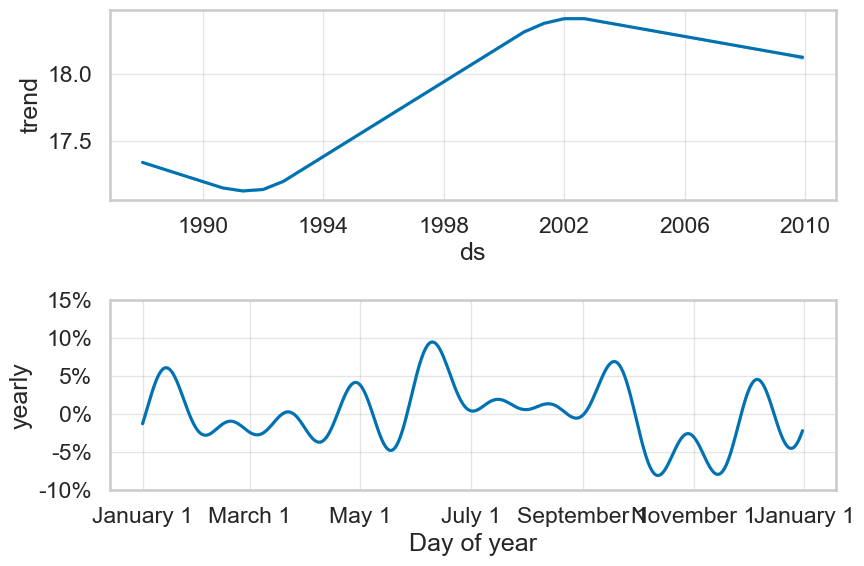

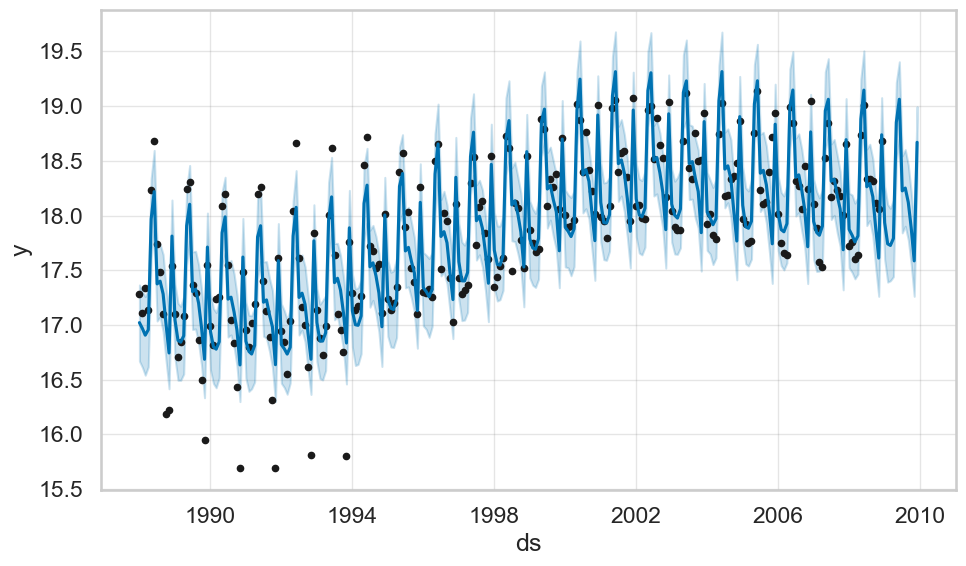

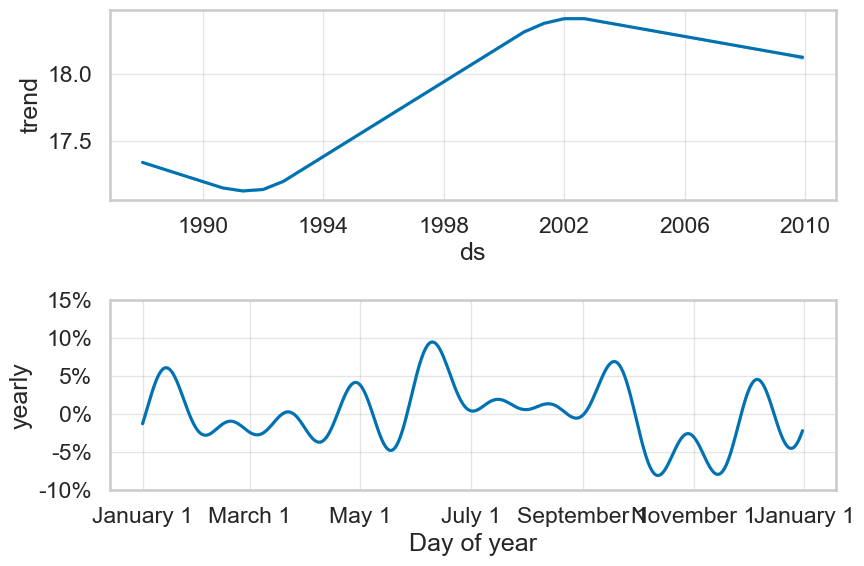

In [23]:
# predict 2009

future = m.make_future_dataframe(periods = 12, freq="MS")
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

In [24]:
forecast = m.predict(future)
preditions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
preditions

ds  yhat  yhat_lower  yhat_upper
0   1988-01-01 17.02       16.65       17.37
1   1988-02-01 16.97       16.62       17.29
2   1988-03-01 16.91       16.53       17.27
3   1988-04-01 16.96       16.61       17.34
4   1988-05-01 17.97       17.64       18.32
..         ...   ...         ...         ...
259 2009-08-01 18.25       17.90       18.59
260 2009-09-01 18.12       17.76       18.46
261 2009-10-01 17.89       17.54       18.24
262 2009-11-01 17.59       17.23       17.91
263 2009-12-01 18.67       18.31       19.02

[264 rows x 4 columns]

In [25]:
df_value_log

ds     y
0   1988-01-01 17.28
1   1988-02-01 17.11
2   1988-03-01 17.34
3   1988-04-01 17.13
4   1988-05-01 18.23
..         ...   ...
415 2022-08-01 18.84
416 2022-09-01 18.64
417 2022-10-01 18.59
418 2022-11-01 18.26
419 2022-12-01 18.68

[420 rows x 2 columns]

In [26]:
actuals = df_value_log.loc[df_value_log['ds'].dt.year <= 2009, ['ds', 'y']].reset_index(drop = True)
actuals = actuals.rename(columns={'y': 'y-actual'})
actuals

ds  y-actual
0   1988-01-01     17.28
1   1988-02-01     17.11
2   1988-03-01     17.34
3   1988-04-01     17.13
4   1988-05-01     18.23
..         ...       ...
259 2009-08-01     18.11
260 2009-09-01     18.05
261 2009-10-01     17.95
262 2009-11-01     18.04
263 2009-12-01     18.52

[264 rows x 2 columns]

In [27]:
# predict values 
model_eval = preditions.merge(actuals, on='ds', how = 'inner')
# model_eval[['yhat', 'yhat_lower', 'yhat_upper', 'y-actual']] = np.exp(model_eval[['yhat', 'yhat_lower', 'yhat_upper', 'y-actual']])
model_eval

ds  yhat  yhat_lower  yhat_upper  y-actual
0   1988-01-01 17.02       16.65       17.37     17.28
1   1988-02-01 16.97       16.62       17.29     17.11
2   1988-03-01 16.91       16.53       17.27     17.34
3   1988-04-01 16.96       16.61       17.34     17.13
4   1988-05-01 17.97       17.64       18.32     18.23
..         ...   ...         ...         ...       ...
259 2009-08-01 18.25       17.90       18.59     18.11
260 2009-09-01 18.12       17.76       18.46     18.05
261 2009-10-01 17.89       17.54       18.24     17.95
262 2009-11-01 17.59       17.23       17.91     18.04
263 2009-12-01 18.67       18.31       19.02     18.52

[264 rows x 5 columns]

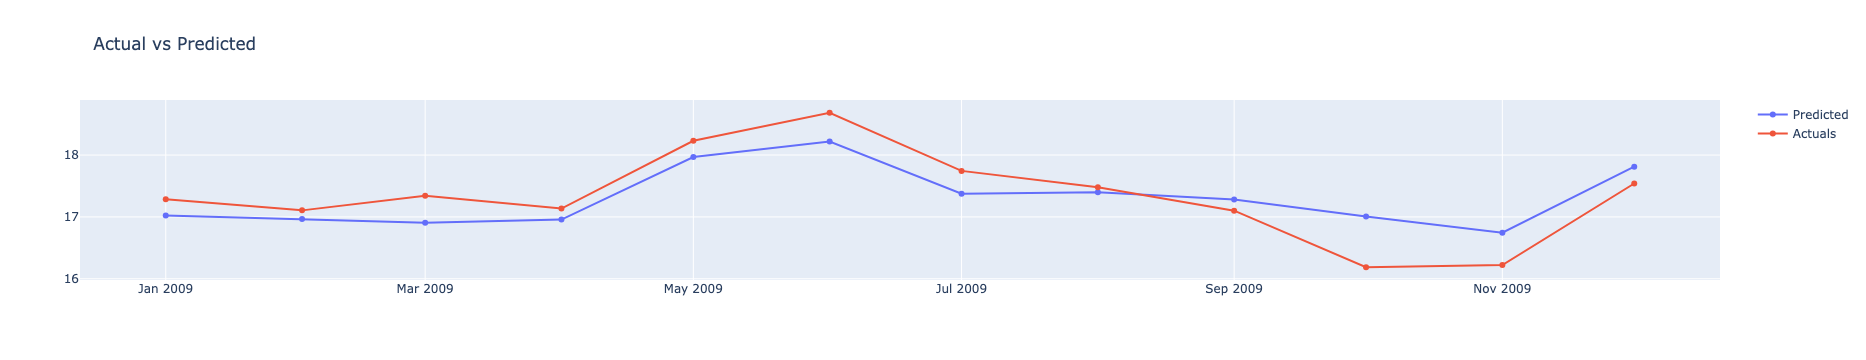

In [28]:
## plot predicted values against actuals
fig = go.Figure()
preds = model_eval.loc[model_eval['ds'].dt.year >= 2009, :]
x_vals = model_eval.loc[model_eval['ds'].dt.year >= 2009, 'ds']
x_vals

# fig = px.line(preds, title='prediction vs actual', )
fig.add_trace(go.Scatter(
    x=x_vals,
    y= model_eval['yhat'], name = 'Predicted'
))
fig.add_trace(go.Scatter(
    x=x_vals,
    y= model_eval['y-actual'], name = 'Actuals'
))

fig.update_layout(title='Actual vs Predicted')
fig.show()

In [29]:
y_actual = model_eval['y-actual']
y_pred = model_eval['yhat']
r2 = r2_score(y_actual, y_pred)
print(f'rsquare value is {r2}')

# RMSE

mse = mean_squared_error(y_actual, y_pred)
print(f'mse value is {mse}')


rsquare value is 0.8527933348968297
mse value is 0.07347563540017925


In [30]:
model_eval_exp = model_eval.copy()
model_eval_exp

ds  yhat  yhat_lower  yhat_upper  y-actual
0   1988-01-01 17.02       16.65       17.37     17.28
1   1988-02-01 16.97       16.62       17.29     17.11
2   1988-03-01 16.91       16.53       17.27     17.34
3   1988-04-01 16.96       16.61       17.34     17.13
4   1988-05-01 17.97       17.64       18.32     18.23
..         ...   ...         ...         ...       ...
259 2009-08-01 18.25       17.90       18.59     18.11
260 2009-09-01 18.12       17.76       18.46     18.05
261 2009-10-01 17.89       17.54       18.24     17.95
262 2009-11-01 17.59       17.23       17.91     18.04
263 2009-12-01 18.67       18.31       19.02     18.52

[264 rows x 5 columns]

In [31]:
model_eval_exp[['yhat', 'yhat_lower', 'yhat_upper', 'y-actual']] = np.exp(model_eval_exp[['yhat', 'yhat_lower', 'yhat_upper', 'y-actual']])

In [32]:
model_eval_exp

ds           yhat    yhat_lower     yhat_upper       y-actual
0   1988-01-01  24,669,918.07 17,081,954.15  34,821,227.56  32,094,345.55
1   1988-02-01  23,373,780.01 16,443,613.74  32,259,075.55  26,852,319.99
2   1988-03-01  22,000,686.50 15,088,600.81  31,651,895.18  34,003,540.09
3   1988-04-01  23,120,158.54 16,408,340.71  33,853,867.66  27,637,080.92
4   1988-05-01  63,640,683.54 45,895,006.69  90,046,371.61  82,665,791.27
..         ...            ...           ...            ...            ...
259 2009-08-01  84,384,746.63 59,171,904.17 119,011,752.43  73,509,042.15
260 2009-09-01  74,102,183.98 51,715,008.57 103,699,030.84  68,682,796.26
261 2009-10-01  58,743,187.18 41,374,115.76  83,499,267.41  62,222,731.18
262 2009-11-01  43,375,012.80 30,373,005.63  60,083,010.32  68,311,251.76
263 2009-12-01 128,158,887.38 89,795,159.02 182,180,561.95 110,266,803.75

[264 rows x 5 columns]

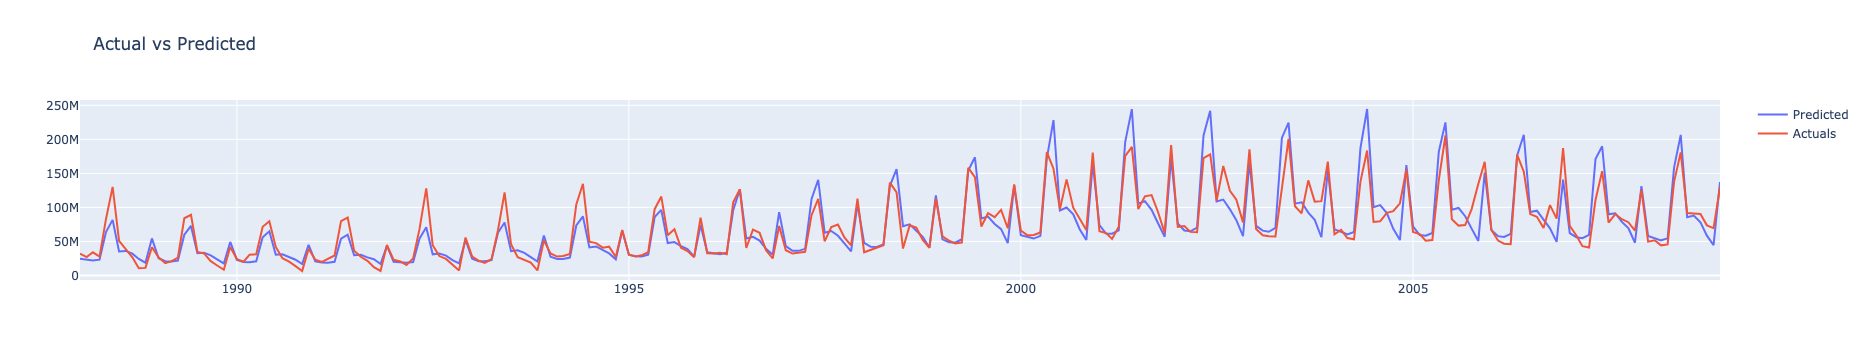

In [37]:
## plot predicted values against actuals
fig = go.Figure()
preds = model_eval_exp.loc[model_eval_exp['ds'].dt.year <= 2008, :]
x_vals = model_eval_exp.loc[model_eval_exp['ds'].dt.year <= 2008, 'ds']
x_vals

# fig = px.line(preds, title='prediction vs actual', )
fig.add_trace(go.Scatter(
    x=x_vals,
    y= model_eval_exp['yhat'], name = 'Predicted'
))
fig.add_trace(go.Scatter(
    x=x_vals,
    y= model_eval_exp['y-actual'], name = 'Actuals'
))

fig.update_layout(title='Actual vs Predicted')
fig.show()

In [43]:
## run MSE Only on 2009 test data range
y_actual = model_eval_exp.loc[ model_eval_exp['ds'].dt.year > 2008, 'y-actual']
y_pred = model_eval_exp.loc[ model_eval_exp['ds'].dt.year > 2008, 'yhat']
r2 = r2_score(y_actual, y_pred)
print(f'TEST rsquare value is {r2}')

# RMSE

mse = mean_squared_error(y_actual, y_pred)
print(f'TEST mse value is {mse}')

TEST rsquare value is 0.6230182094735505
TEST mse value is 404539829442169.7


In [42]:
## run MSE Only on 2009 test data range
y_actual = model_eval_exp.loc[ model_eval_exp['ds'].dt.year < 2009, 'y-actual']
y_pred = model_eval_exp.loc[ model_eval_exp['ds'].dt.year < 2009, 'yhat']
r2 = r2_score(y_actual, y_pred)
print(f' TRAIN rsquare value is {r2}')

# RMSE

mse = mean_squared_error(y_actual, y_pred)
print(f'TRAIN mse value is {mse}')

## slight overfit 

 TRAIN rsquare value is 0.8119522865813442
TRAIN mse value is 401749451271475.2


In [ ]:
# rmse - how far off predictions are ~"on avg"



In [39]:
model_eval_exp[['ds','yhat', 'y-actual']]

ds           yhat       y-actual
0   1988-01-01  24,669,918.07  32,094,345.55
1   1988-02-01  23,373,780.01  26,852,319.99
2   1988-03-01  22,000,686.50  34,003,540.09
3   1988-04-01  23,120,158.54  27,637,080.92
4   1988-05-01  63,640,683.54  82,665,791.27
..         ...            ...            ...
259 2009-08-01  84,384,746.63  73,509,042.15
260 2009-09-01  74,102,183.98  68,682,796.26
261 2009-10-01  58,743,187.18  62,222,731.18
262 2009-11-01  43,375,012.80  68,311,251.76
263 2009-12-01 128,158,887.38 110,266,803.75

[264 rows x 3 columns]

In [258]:
# scale data 

# Bin

### Model 3a: USD Only no CV, multiple vals per day 

In [30]:
### backup - make monthly ammounts daily

In [31]:
m=Prophet()

In [138]:
model_data = model_data.loc[model_data['ds'].dt.year <= 2008, ['ds', 'y']].reset_index(drop = True)
model_data

ds             y
0     1988-01-01  2.601163e+05
1     1988-01-01  9.561563e+05
2     1988-01-01  6.839239e+05
3     1988-01-01  1.620199e+05
4     1988-01-01  5.543610e+05
...          ...           ...
15670 2008-12-01  1.186018e+06
15671 2008-12-01  5.385155e+05
15672 2008-12-01  1.200018e+06
15673 2008-12-01  1.662313e+05
15674 2008-12-01  7.877815e+05

[15675 rows x 2 columns]

In [139]:
m.fit(model_data)

13:30:32 - cmdstanpy - INFO - Chain [1] start processing
13:30:32 - cmdstanpy - INFO - Chain [1] done processing


In [144]:
future = m.make_future_dataframe(periods = 24, freq="MS")

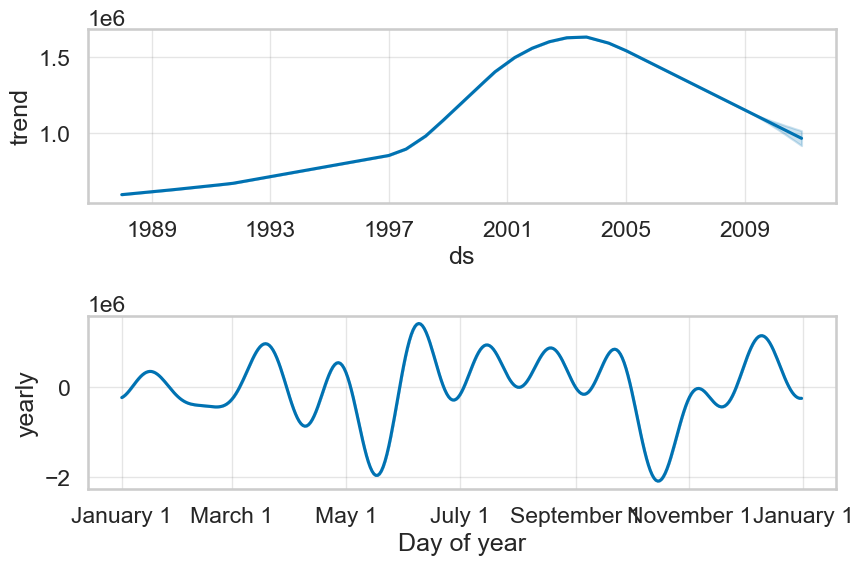

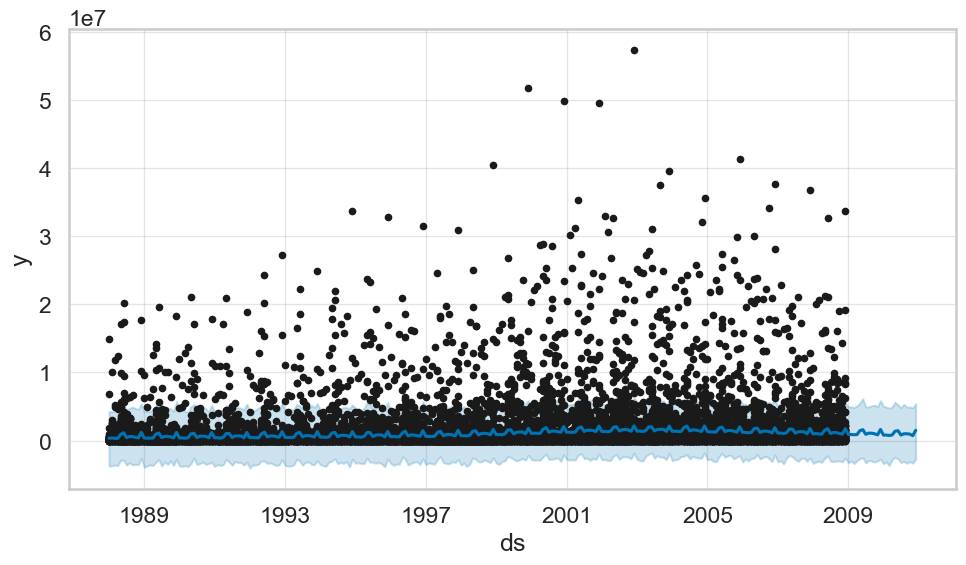

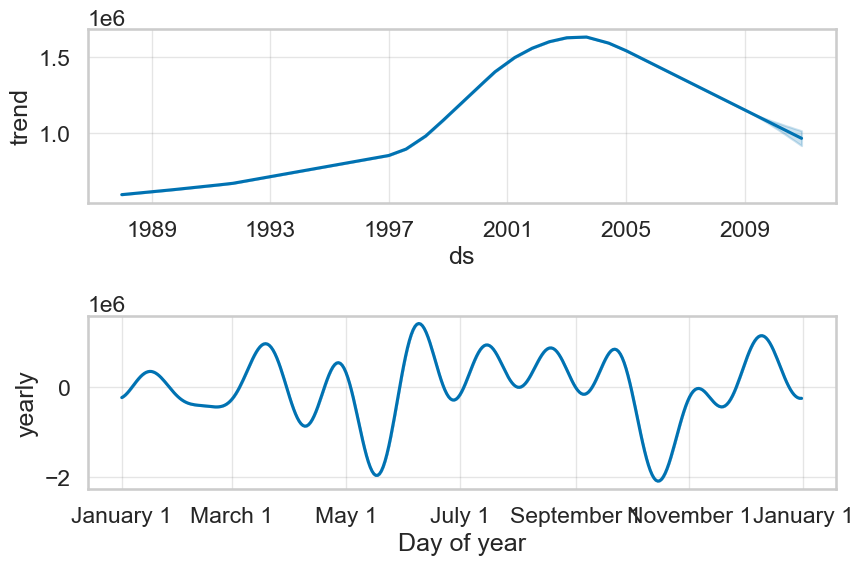

In [145]:
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

In [148]:
future

ds
0   1988-01-01
1   1988-02-01
2   1988-03-01
3   1988-04-01
4   1988-05-01
..         ...
271 2010-08-01
272 2010-09-01
273 2010-10-01
274 2010-11-01
275 2010-12-01

[276 rows x 1 columns]

In [188]:
model_data

ds      y-actual
0     1988-01-01  2.601163e+05
1     1988-01-01  9.561563e+05
2     1988-01-01  6.839239e+05
3     1988-01-01  1.620199e+05
4     1988-01-01  5.543610e+05
...          ...           ...
15670 2008-12-01  1.186018e+06
15671 2008-12-01  5.385155e+05
15672 2008-12-01  1.200018e+06
15673 2008-12-01  1.662313e+05
15674 2008-12-01  7.877815e+05

[15675 rows x 2 columns]

In [195]:
actuals = df_value.loc[df_value['ds'].dt.year <= 2011, ['ds', 'y']].reset_index(drop = True)
actuals = actuals.rename(columns={'y': 'y-actual'})
actuals

ds      y-actual
0     1998-06-01  4.185642e+04
1     1998-06-01  3.414800e+04
2     1998-06-01  7.595672e+05
3     1998-06-01  6.554712e+04
4     1998-06-01  7.636548e+04
...          ...           ...
18070 1990-04-01  7.596545e+06
18071 1990-04-01  9.674693e+05
18072 1990-04-01  9.460215e+03
18073 1990-04-01  1.441996e+06
18074 1990-04-01  1.156025e+04

[18075 rows x 2 columns]

In [192]:
# Python
forecast = m.predict(future)
preditions = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]



In [193]:
preditions

ds          yhat    yhat_lower    yhat_upper
0   1988-01-01  3.541424e+05 -3.946636e+06  4.758455e+06
1   1988-02-01  3.809986e+05 -3.792563e+06  4.526336e+06
2   1988-03-01  3.452039e+05 -3.628777e+06  4.293241e+06
3   1988-04-01  3.313917e+05 -3.656048e+06  4.542971e+06
4   1988-05-01  9.107866e+05 -3.090093e+06  5.028705e+06
..         ...           ...           ...           ...
271 2010-08-01  1.004864e+06 -2.913281e+06  4.996914e+06
272 2010-09-01  1.008057e+06 -3.205445e+06  5.285244e+06
273 2010-10-01  9.572838e+05 -3.133635e+06  4.901075e+06
274 2010-11-01  7.346515e+05 -3.283870e+06  4.925687e+06
275 2010-12-01  1.512833e+06 -2.843145e+06  5.444177e+06

[276 rows x 4 columns]

In [198]:
model_eval = preditions.merge(actuals, on='ds', how = 'inner')
model_eval

ds          yhat    yhat_lower    yhat_upper      y-actual
0     1988-01-01  3.541424e+05 -3.946636e+06  4.758455e+06  6.803156e+03
1     1988-01-01  3.541424e+05 -3.946636e+06  4.758455e+06  1.037830e+04
2     1988-01-01  3.541424e+05 -3.946636e+06  4.758455e+06  6.839858e+04
3     1988-01-01  3.541424e+05 -3.946636e+06  4.758455e+06  3.111720e+05
4     1988-01-01  3.541424e+05 -3.946636e+06  4.758455e+06  5.670410e+05
...          ...           ...           ...           ...           ...
17277 2010-12-01  1.512833e+06 -2.843145e+06  5.444177e+06  3.825662e+05
17278 2010-12-01  1.512833e+06 -2.843145e+06  5.444177e+06  1.813525e+06
17279 2010-12-01  1.512833e+06 -2.843145e+06  5.444177e+06  1.088837e+06
17280 2010-12-01  1.512833e+06 -2.843145e+06  5.444177e+06  2.189043e+06
17281 2010-12-01  1.512833e+06 -2.843145e+06  5.444177e+06  1.080127e+06

[17282 rows x 5 columns]

In [ ]:
x_vals = model_eval['ds']


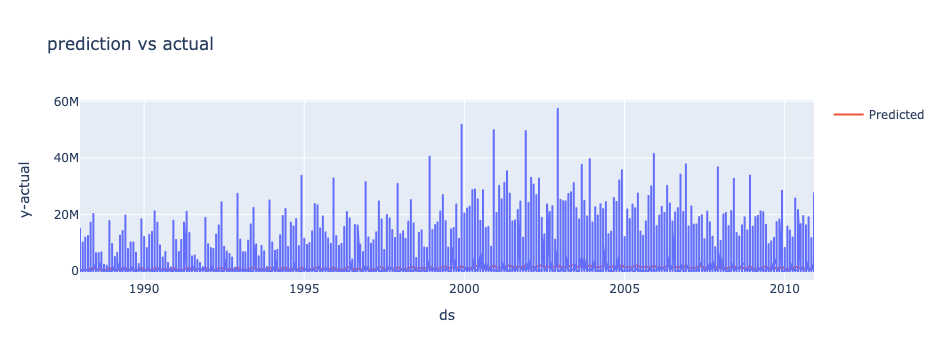

In [199]:
## plot predicted values against actuals
import plotly.graph_objects as go

fig = go.Figure()
x_vals = model_eval['ds']

fig = px.line(model_eval, x=x_vals, y='y-actual', title='prediction vs actual')
fig.add_trace(go.Scatter(
    x=x_vals,
    y= model_eval['yhat'], name = 'Predicted'
))
fig.show()

<Axes: >

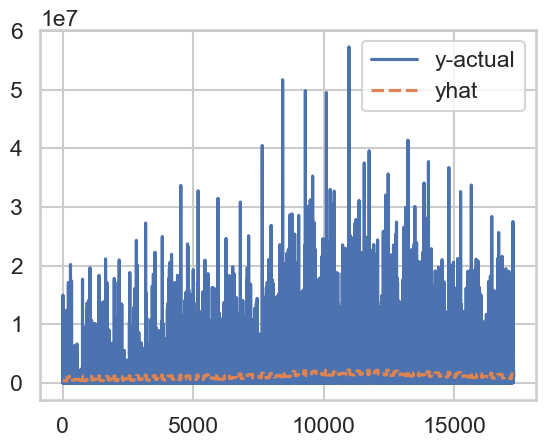

In [202]:
sns.lineplot(data=model_eval[['y-actual', 'yhat']])

In [207]:





y_actual = model_eval['y-actual']
y_pred = model_eval['yhat']
r2 = r2_score(y_actual, y_pred)
r2

# RMSE
mse = mean_squared_error(y_actual, y_pred)
mse

0.020740050078874583

In [209]:
# RMSE


mse = mean_squared_error(y_actual, y_pred)
mse

9870292621209.807

### df_simple

In [13]:
# import simple clean data
df_simple = pd.read_csv('data/data_simple_clean.csv', index_col=0)
df_simple.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/data_simple_clean.csv'

In [ ]:
data

In [12]:
# drop commodity column
df_simple = df_simple.drop(columns=['Commodity'])

NameError: name 'df_simple' is not defined

In [11]:
# group by to have total values by month year
df_simple = df_simple.groupby('Period', as_index=False).sum()
df_simple

Period    Value_$  Quantity_kg
0    1988-01-01   21197107      1797439
1    1988-02-01   16588066      1274276
2    1988-03-01   19812354      1586821
3    1988-04-01   16143080      1553369
4    1988-05-01   42242858      3957311
..          ...        ...          ...
424  2023-05-01  299398613     11446738
425  2023-06-01  473552801     14670111
426  2023-07-01  292203709      8191749
427  2023-08-01  233600838      6647827
428  2023-09-01  216174207      6387298

[429 rows x 3 columns]

In [13]:
df_quantity = df_simple[['Period','Quantity_kg']].copy()
df_quantity

Period  Quantity_kg
0    1988-01-01      1797439
1    1988-02-01      1274276
2    1988-03-01      1586821
3    1988-04-01      1553369
4    1988-05-01      3957311
..          ...          ...
424  2023-05-01     11446738
425  2023-06-01     14670111
426  2023-07-01      8191749
427  2023-08-01      6647827
428  2023-09-01      6387298

[429 rows x 2 columns]

## Model 1 with FB Prophet -Value($) with simple data

In [15]:
df_simple['Period'] = pd.to_datetime(df_simple['Period'])


In [16]:
m = Prophet()

In [17]:
m.fit(df_value)

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [ ]:
future = m.make_future_dataframe(periods = 60, freq="MS")

In [ ]:
future.tail(10)

In [ ]:
forecast = m.predict(future)
fig = m.plot(forecast)

In [ ]:
m.plot_components(forecast)

In [ ]:
# interpretation? 
# seasonality? 
# how long should forecast window be?

## Model 2 FB Prophet with df_simple Value and quantity

In [11]:
df_simple

NameError: name 'df_simple' is not defined

In [19]:
## 

df_simple = df_simple.rename(columns={ df_simple.columns[0]: "ds" , df_simple.columns[1]:'y', df_simple.columns[2]:'quantity_kg'})
df_simple

ds          y  quantity_kg
0   1988-01-01   21197107      1797439
1   1988-02-01   16588066      1274276
2   1988-03-01   19812354      1586821
3   1988-04-01   16143080      1553369
4   1988-05-01   42242858      3957311
..         ...        ...          ...
424 2023-05-01  299398613     11446738
425 2023-06-01  473552801     14670111
426 2023-07-01  292203709      8191749
427 2023-08-01  233600838      6647827
428 2023-09-01  216174207      6387298

[429 rows x 3 columns]

In [20]:
m = Prophet()

In [21]:
# regressor - additional features in df passing into model for training
m.add_regressor('quantity_kg')

In [22]:
m.fit(df_simple)

12:12:13 - cmdstanpy - INFO - Chain [1] start processing
12:12:13 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
# predict 2 years, 24 months 
future = m.make_future_dataframe(periods = 24, freq="MS")

In [24]:
len(df_simple)

429

In [25]:
df_simple_tail = df_simple.sort_values(by='ds').reset_index(drop=True).tail(24)
df_simple_tail = df_simple_tail.iloc[:,-1]
df_simple_tail

405     6484241
406     6082272
407     9751786
408     7528603
409     5465581
410     4181104
411     3846165
412     9398555
413    16599103
414    11518401
415    10234934
416     8079623
417     6083256
418     5746809
419     9040041
420     9315981
421     5900774
422     5934760
423     3382583
424    11446738
425    14670111
426     8191749
427     6647827
428     6387298
Name: quantity_kg, dtype: int64

In [26]:
quantity_feat = pd.DataFrame(pd.concat([df_simple['quantity_kg'], df_simple_tail], axis = 0)).reset_index(drop = True)
quantity_feat

quantity_kg
0        1797439
1        1274276
2        1586821
3        1553369
4        3957311
..           ...
448     11446738
449     14670111
450      8191749
451      6647827
452      6387298

[453 rows x 1 columns]

In [27]:
type(df_simple_tail)

pandas.core.series.Series

In [28]:
# type(quantity_feat)
type(future)

pandas.core.frame.DataFrame

In [29]:
df_pred = pd.concat([future, quantity_feat], axis = 1)
df_pred

ds  quantity_kg
0   1988-01-01      1797439
1   1988-02-01      1274276
2   1988-03-01      1586821
3   1988-04-01      1553369
4   1988-05-01      3957311
..         ...          ...
448 2025-05-01     11446738
449 2025-06-01     14670111
450 2025-07-01      8191749
451 2025-08-01      6647827
452 2025-09-01      6387298

[453 rows x 2 columns]

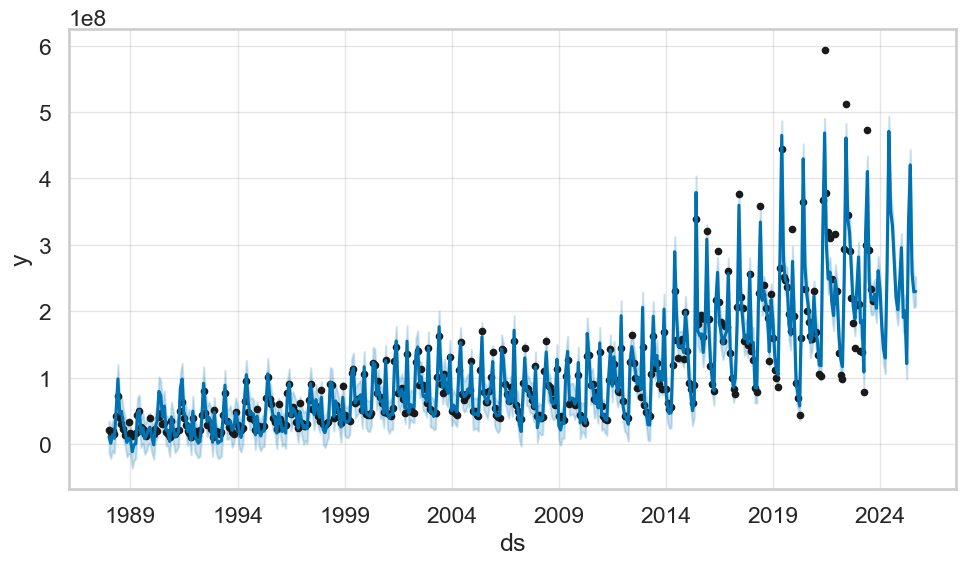

In [30]:
forecast = m.predict(df_pred)
fig = m.plot(forecast)

In [31]:
forecast

ds         trend    yhat_lower    yhat_upper   trend_lower  \
0   1988-01-01  9.033847e+07 -1.284364e+07  3.477380e+07  9.033847e+07   
1   1988-02-01  9.041684e+07 -2.126554e+07  2.433425e+07  9.041684e+07   
2   1988-03-01  9.049016e+07 -9.670563e+06  3.606095e+07  9.049016e+07   
3   1988-04-01  9.056854e+07 -1.345358e+07  3.308411e+07  9.056854e+07   
4   1988-05-01  9.064438e+07  2.657978e+07  7.150217e+07  9.064438e+07   
..         ...           ...           ...           ...           ...   
448 2025-05-01  1.492907e+08  3.079444e+08  3.539041e+08  1.483982e+08   
449 2025-06-01  1.498036e+08  3.960632e+08  4.432014e+08  1.488327e+08   
450 2025-07-01  1.502998e+08  2.357726e+08  2.808158e+08  1.492554e+08   
451 2025-08-01  1.508126e+08  2.054410e+08  2.535672e+08  1.496940e+08   
452 2025-09-01  1.513255e+08  2.078826e+08  2.515738e+08  1.501175e+08   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0    9.033847e+07   -7.891036e+07         -7.891036e+07         -7.891036e+07   
1    9.041684e+07   -8.900169e+07         -8.900169e+07         -8.900169e+07   
2    9.049016e+07   -7.616279e+07         -7.616279e+07         -7.616279e+07   
3    9.056854e+07   -8.160344e+07         -8.160344e+07         -8.160344e+07   
4    9.064438e+07   -4.136208e+07         -4.136208e+07         -4.136208e+07   
..            ...             ...                   ...                   ...   
448  1.499584e+08    1.816183e+08          1.816183e+08          1.816183e+08   
449  1.505346e+08    2.706299e+08          2.706299e+08          2.706299e+08   
450  1.511286e+08    1.071778e+08          1.071778e+08          1.071778e+08   
451  1.516833e+08    7.852110e+07          7.852110e+07          7.852110e+07   
452  1.522317e+08    7.861769e+07          7.861769e+07          7.861769e+07   

     extra_regressors_additive  ...   quantity_kg  quantity_kg_lower  \
0                -7.940421e+07  ... -7.940421e+07      -7.940421e+07   
1                -9.502456e+07  ... -9.502456e+07      -9.502456e+07   
2                -8.569274e+07  ... -8.569274e+07      -8.569274e+07   
3                -8.669153e+07  ... -8.669153e+07      -8.669153e+07   
4                -1.491581e+07  ... -1.491581e+07      -1.491581e+07   
..                         ...  ...           ...                ...   
448               2.086999e+08  ...  2.086999e+08       2.086999e+08   
449               3.049418e+08  ...  3.049418e+08       3.049418e+08   
450               1.115140e+08  ...  1.115140e+08       1.115140e+08   
451               6.541631e+07  ...  6.541631e+07       6.541631e+07   
452               5.763756e+07  ...  5.763756e+07       5.763756e+07   

     quantity_kg_upper        yearly  yearly_lower  yearly_upper  \
0        -7.940421e+07  4.938544e+05  4.938544e+05  4.938544e+05   
1        -9.502456e+07  6.022872e+06  6.022872e+06  6.022872e+06   
2        -8.569274e+07  9.529953e+06  9.529953e+06  9.529953e+06   
3        -8.669153e+07  5.088096e+06  5.088096e+06  5.088096e+06   
4        -1.491581e+07 -2.644628e+07 -2.644628e+07 -2.644628e+07   
..                 ...           ...           ...           ...   
448       2.086999e+08 -2.708159e+07 -2.708159e+07 -2.708159e+07   
449       3.049418e+08 -3.431185e+07 -3.431185e+07 -3.431185e+07   
450       1.115140e+08 -4.336133e+06 -4.336133e+06 -4.336133e+06   
451       6.541631e+07  1.310479e+07  1.310479e+07  1.310479e+07   
452       5.763756e+07  2.098012e+07  2.098012e+07  2.098012e+07   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
448                   0.0                         0.0   
449         

In [32]:
# yhat actual predicted target value
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
448 2025-05-01  3.309090e+08  3.079444e+08  3.539041e+08
449 2025-06-01  4.204335e+08  3.960632e+08  4.432014e+08
450 2025-07-01  2.574777e+08  2.357726e+08  2.808158e+08
451 2025-08-01  2.293337e+08  2.054410e+08  2.535672e+08
452 2025-09-01  2.299432e+08  2.078826e+08  2.515738e+08

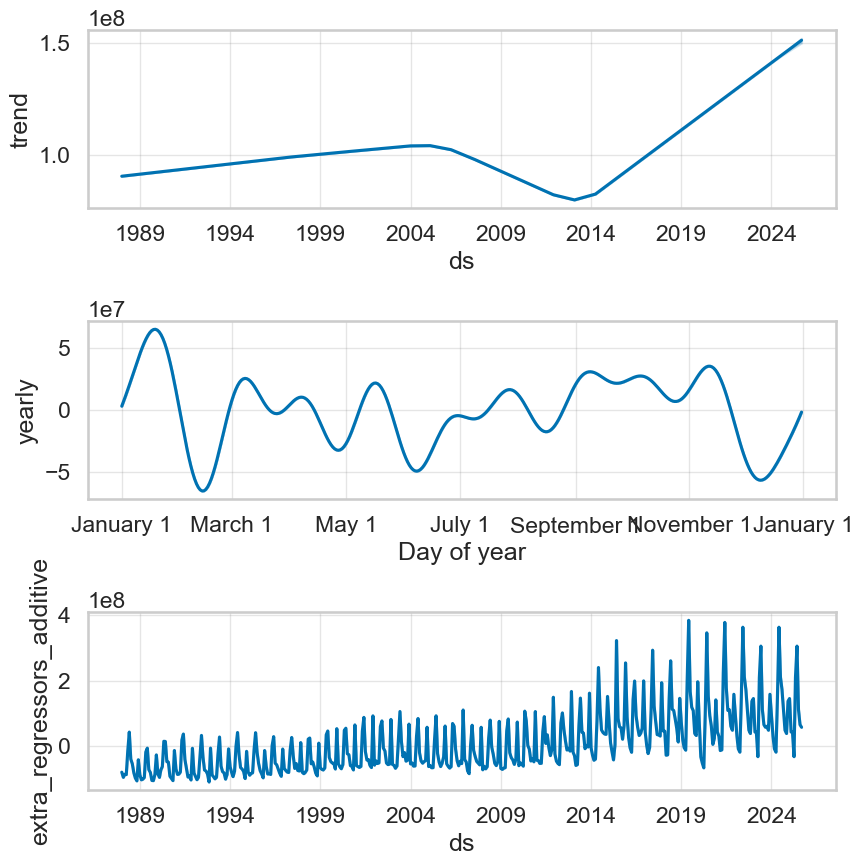

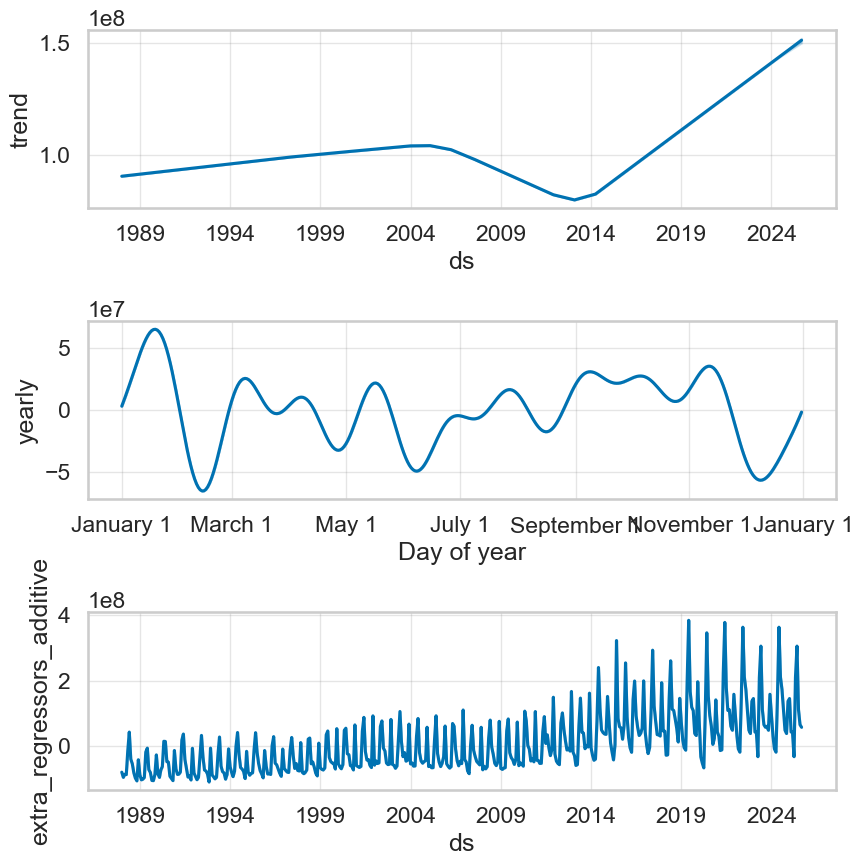

In [33]:
m.plot_components(forecast)

In [37]:
m.regressor_coefficients(forecast)

AttributeError: 'Prophet' object has no attribute 'regressor_coefficients'

### Model 4: USD Only with CV (attempt)

In [88]:
start_date = df_value['ds'].min().date()

end_date = df_value['ds'].max().date()

cutoffs = pd.date_range(start=start_date, end=end_date, freq='1MS')
print(cutoffs)

DatetimeIndex(['1988-01-01', '1988-02-01', '1988-03-01', '1988-04-01',
               '1988-05-01', '1988-06-01', '1988-07-01', '1988-08-01',
               '1988-09-01', '1988-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', length=420, freq='MS')


In [92]:
initial= start_date - end_date
initial

datetime.timedelta(days=-12753)

In [101]:
initial

datetime.timedelta(days=-12753)

In [93]:
initial * .7

datetime.timedelta(days=-8928, seconds=77760)

In [118]:
initial_train_size

21441

In [127]:
from prophet.diagnostics import cross_validation, performance_metrics

# Set initial train dataset size (e.g., 80% of the data)
initial_train_size = int(len(df_value) * 0.8)

# Set horizon (e.g., forecast one year into the future)
horizon = '30 days'

# Set period (e.g., spacing between cutoff dates)
period = '180 days'  # Monthly data, so using 30 days as an example


In [128]:
df_cv = cross_validation(m, initial='{} days'.format(initial_train_size), horizon=horizon)

ValueError: Less data than horizon after initial window. Make horizon or initial shorter.

In [124]:
# df_cv = cross_validation(model=m, initial='' horizon='365 days', cutoffs=cutoffs)

In [47]:
m.fit(df_value)

11:26:37 - cmdstanpy - INFO - Chain [1] start processing
11:26:37 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
# 
df_full['Period'] = pd.to_datetime(df_full['Period'])

In [9]:
df_full.dtypes

Period            datetime64[ns]
Commodity                 object
Province                  object
Country                   object
State                     object
Quantity_kg                int64
Value-adjusted           float64
year                       int64
GDP-USD                  float64
continent                 object
dtype: object

In [12]:
df_value = df_simple[['Period','Value_$']].copy()
df_value

Period    Value_$
0    1988-01-01   21197107
1    1988-02-01   16588066
2    1988-03-01   19812354
3    1988-04-01   16143080
4    1988-05-01   42242858
..          ...        ...
424  2023-05-01  299398613
425  2023-06-01  473552801
426  2023-07-01  292203709
427  2023-08-01  233600838
428  2023-09-01  216174207

[429 rows x 2 columns]

In [48]:
future = m.make_future_dataframe(periods = 60, freq="MS")

In [146]:
future

ds
0   1988-01-01
1   1988-02-01
2   1988-03-01
3   1988-04-01
4   1988-05-01
..         ...
271 2010-08-01
272 2010-09-01
273 2010-10-01
274 2010-11-01
275 2010-12-01

[276 rows x 1 columns]

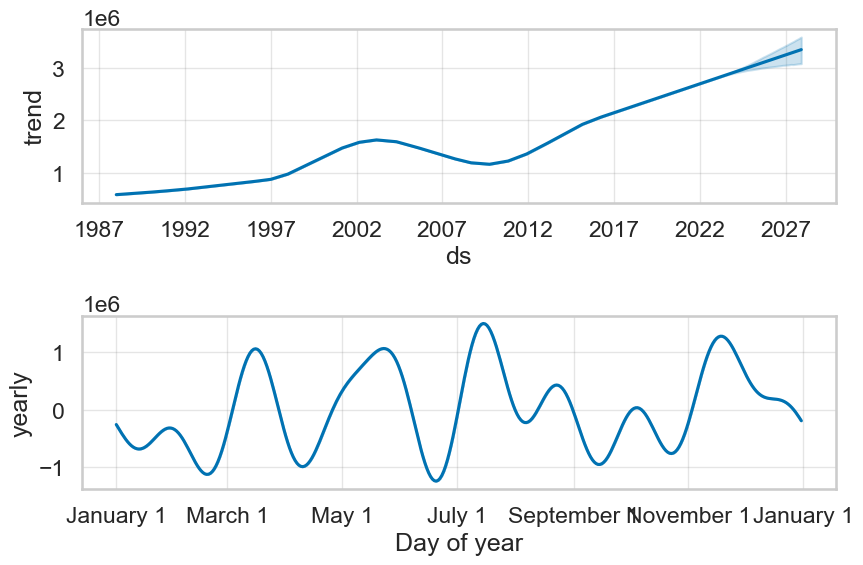

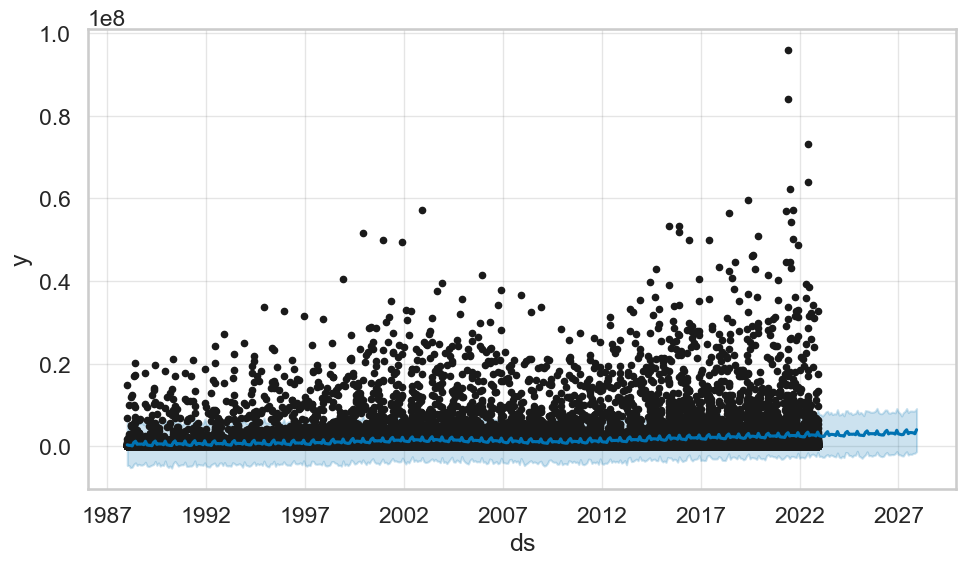

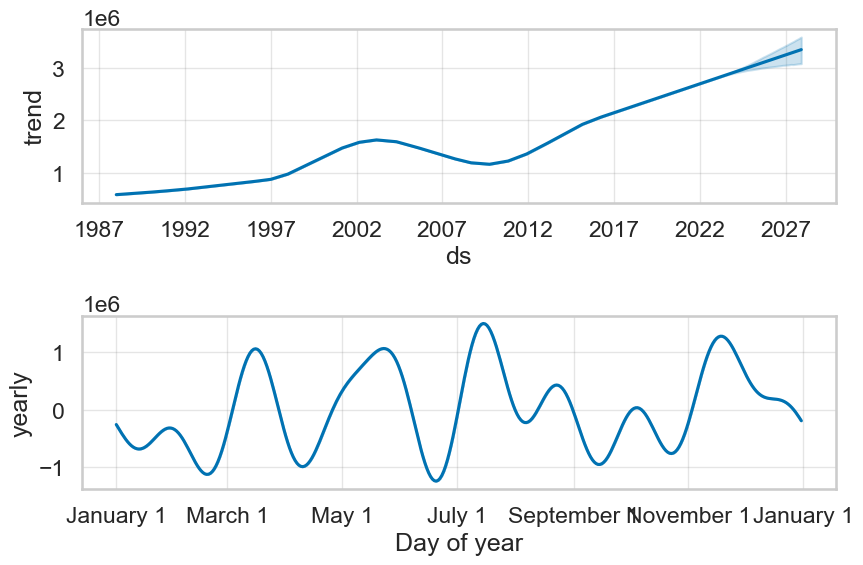

In [50]:
forecast = m.predict(future)
fig = m.plot(forecast)
m.plot_components(forecast)

### Model 5: Simple Linear Regression

In [103]:
model_data

ds             y       GDP-USD
0     2017-05-01  3.023517e+06  1.947734e+13
1     2017-05-01  2.480830e+07  1.947734e+13
2     2017-05-01  3.833044e+04  1.947734e+13
3     2017-05-01  1.214764e+05  1.947734e+13
4     2017-05-01  3.830383e+05  1.947734e+13
...          ...           ...           ...
54047 1990-04-01  7.596545e+06  5.963144e+12
54048 1990-04-01  9.674693e+05  5.963144e+12
54049 1990-04-01  9.460215e+03  5.963144e+12
54050 1990-04-01  1.441996e+06  5.963144e+12
54051 1990-04-01  1.156025e+04  5.963144e+12

[26802 rows x 3 columns]

In [106]:
model_data = model_data.sort_values(by='ds', ascending = True)
model_data

ds             y       GDP-USD
41099 1988-01-01  2.601163e+05  5.236438e+12
41128 1988-01-01  9.561563e+05  5.236438e+12
41127 1988-01-01  6.839239e+05  5.236438e+12
41126 1988-01-01  1.620199e+05  5.236438e+12
41125 1988-01-01  5.543610e+05  5.236438e+12
...          ...           ...           ...
16346 2022-12-01  2.374817e+06  2.546270e+13
16345 2022-12-01  1.588992e+04  2.546270e+13
16344 2022-12-01  4.887179e+05  2.546270e+13
16292 2022-12-01  2.571302e+06  2.546270e+13
16316 2022-12-01  6.391202e+03  2.546270e+13

[26802 rows x 3 columns]

In [ ]:
model_data['ds_ret'] = model_data['ds']